# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM, imbalance
from util.evaluation import odds_ratios, binned_residuals, plot_binned_residuals, to_frame
from util.fg_data import clean, get_data

from tqdm import tqdm
import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime as dt

plt.style.use('seaborn-darkgrid')
sns.set_palette('colorblind')

## Preprocessing

In [2]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df['year'] = df['year']-df['year'].min()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   distance       18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [ ]:
binary = ['altitude', 'iced', 'turf', 'postseason', 'away_game', 'precipitation']
continuous = ['distance', 'year', 'seasons', 'temperature', 'wind', 'pressure']

In [6]:
df.head()

,good,distance,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,0,17,22,0,10,1,0,0,1,0,1
2185,1,27,0,17,22,0,10,1,0,0,1,0,1
4565,1,36,0,17,26,0,13,0,0,1,0,0,5
8564,1,24,0,17,16,0,16,1,0,0,1,1,1
8628,1,40,0,17,16,0,16,1,0,0,1,1,1


## Correlations

In [7]:
from util.metrics import correlations
df_corr = correlations(df, continuous, binary)
df_corr
# print(df_corr[abs(df_corr['corr'])>0.3].sort_values('corr').round(2).to_latex())
# print(df.loc[:,continuous].corr('spearman').round(2).to_latex())

,cov 1,cov 2,corr,p,type
0,altitude,iced,-0.022132,NaN,tetrachoric
1,altitude,turf,-1.000000,NaN,tetrachoric
2,altitude,postseason,0.237681,NaN,tetrachoric
3,altitude,away_game,-0.056016,NaN,tetrachoric
4,altitude,precipitation,-0.441762,NaN,tetrachoric
...,...,...,...,...,...
61,seasons,wind,-0.101532,2.826191e-44,pearsons
62,seasons,pressure,-0.013511,6.392745e-02,pearsons
63,temperature,wind,-0.258234,4.019768e-284,pearsons
64,temperature,pressure,-0.002755,7.056319e-01,pearsons


In [ ]:
# sns.set(font_scale=1)
# ax = sns.pairplot(df.loc[:,continuous].sample(frac=0.5), diag_kind='hist', plot_kws=dict(s=10, edgecolor="b", linewidth=1))

## Finding H

In [ ]:
from matching.cem import get_imbalance_params

rows = []
cont_bins = range(1, 10)

for h, treatment in tqdm(itertools.product(cont_bins,binary), total=len(binary)*len(cont_bins)):
    bins = get_imbalance_params(df.drop([treatment, 'good'], axis=1),
                                'l1', continuous, h)
    l1 = imbalance(df.drop('good', axis=1), treatment, 'l1', bins)
    rows.append({'L1':l1, 'treatment':treatment, 'H':h})

imb = pd.DataFrame.from_records(rows).loc[imb['L1']<1, :]

ax = sns.lineplot(x='H', y='L1', data=imb, hue='treatment', style='treatment', markers=True)
ax.set_title('L1 profile of raw data', size=16)
ax.set_xlabel('H', size=16)
ax.set_ylabel('L1    ', size=16, rotation='horizontal')
ax.tick_params(labelsize=12, size=2)

## Without Matching

#### Imbalance

In [409]:
def pp(val):
    if val<0.01:
        return '***'
    elif val<0.05:
        return '**'
    elif val<0.1:
        return '*'
    return ''

In [12]:
from matching.cem import UnivariateBalance
multi = {}
imb = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    multi[t] = cem.preimbalance
    ub = UnivariateBalance(df.drop('good', axis=1), t, 'l1', cem.bins).summary
    imb[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp) 

df_imb = pd.DataFrame.from_dict(imb, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))
# print(df_imb.to_latex())

In [15]:
print(df_imb.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  altitude &      iced &      turf & postseason & away\_game & precipitation \\
\midrule
altitude      &       NaN &     0.002 &  0.062*** &   0.027*** &    0.005* &      0.025*** \\
away\_game     &    0.036* &     0.012 &      0.01 &      0.013 &       NaN &         0.016 \\
distance      &  0.047*** &  0.088*** &     0.008 &      0.02* &   0.014** &        0.022* \\
iced          &     0.006 &       NaN &     0.001 &    0.028** &     0.005 &         0.003 \\
postseason    &  0.031*** &    0.01** &  0.008*** &        NaN &     0.002 &      0.025*** \\
precipitation &  0.056*** &     0.002 &  0.033*** &   0.046*** &     0.005 &           NaN \\
pressure      &     0.013 &  0.235*** &     0.001 &    0.021** &     0.005 &         0.023 \\
seasons       &  0.053*** &   0.022** &  0.053*** &      0.031 &     0.006 &      0.052*** \\
temperature   &  0.162*** &    0.025* &  0.085*** &   0.268*** &     0.011 &      0.142*** \\
turf          &  0.461*** 

#### Regression

In [370]:
formulas_s = {t:f'good ~ {t}' for t in df.drop('good', axis=1).columns}
formula_0 = {'main effects':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns)}
formula_1 = {'interactions':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns) + f'+ iced*pressure + altitude*distance'}
formula_2 = {'full':'good ~ ' + ' + '.join(df.drop(['good'], axis=1).columns) + f'+ np.log(wind+1) + np.log(seasons) + iced*pressure + altitude*distance + altitude*np.log(distance)'}
formulas = {**formulas_s, **formula_0, **formula_1, **formula_2}

In [372]:
df_unmatched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model'])
results_unmatched = {}
for name, formula in formulas.items():
    glm = smf.glm(formula, data=df, family=sm.families.Binomial())
    result = glm.fit(method='bfgs', maxiter=10000)
    results_unmatched[name] = result
    df_unmatched = pd.concat((df_unmatched, pd.DataFrame({'coef':result.params, 'P>|z|':result.pvalues, 'bse': result.bse, 'model':name})))

df_unmatched.index.rename('covariate', inplace=True)
df_unmatched = df_unmatched.reset_index('covariate')
results_unmatched = pd.Series(results_unmatched, name='model')

In [373]:
df_unmatched.head()

,covariate,coef,P>|z|,bse,model
0,Intercept,6.091820,0.000000e+00,0.113231,distance
1,distance,-0.108927,0.000000e+00,0.002568,distance
2,Intercept,1.465018,0.000000e+00,0.037945,year
3,year,0.024866,3.888169e-12,0.003582,year
4,Intercept,1.563687,0.000000e+00,0.036535,seasons


In [374]:
results_unmatched.head()

distance       <statsmodels.genmod.generalized_linear_model.G...
year           <statsmodels.genmod.generalized_linear_model.G...
seasons        <statsmodels.genmod.generalized_linear_model.G...
temperature    <statsmodels.genmod.generalized_linear_model.G...
altitude       <statsmodels.genmod.generalized_linear_model.G...
Name: model, dtype: object

#### DOPS, SATT, coefs, OR and p-values

Note each row is a separate regression

In [468]:
df_simple = pd.concat(results_unmatched.loc[df.drop('good', axis=1).columns].apply(lambda x: to_frame(x.summary())).to_list())
df_simple['treatment'] = np.ravel([[i]*2 for i in df.drop('good', axis=1).columns])
df_simple = df_simple.set_index('treatment', append=True).reorder_levels([1,0])
print(df_simple.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
         &          &    coef &  std err &       z &  P>|z| &  [0.025 &  0.975] \\
treatment & covariate &         &          &         &        &         &         \\
\midrule
distance & Intercept &  6.0918 &    0.113 &  53.800 &  0.000 &   5.870 &   6.314 \\
         & distance & -0.1089 &    0.003 & -42.413 &  0.000 &  -0.114 &  -0.104 \\
year & Intercept &  1.4650 &    0.038 &  38.609 &  0.000 &   1.391 &   1.539 \\
         & year &  0.0249 &    0.004 &   6.941 &  0.000 &   0.018 &   0.032 \\
seasons & Intercept &  1.5637 &    0.037 &  42.800 &  0.000 &   1.492 &   1.635 \\
         & seasons &  0.0169 &    0.004 &   4.220 &  0.000 &   0.009 &   0.025 \\
temperature & Intercept &  1.5949 &    0.041 &  39.268 &  0.000 &   1.515 &   1.674 \\
         & temperature &  0.0065 &    0.002 &   2.806 &  0.005 &   0.002 &   0.011 \\
altitude & Intercept &  1.6914 &    0.020 &  82.612 &  0.000 &   1.651 &   1.732 \\
         & altitude &  0.1039 &    0.114

In [28]:
def dops(res):
    assert len(res.params) < 3, 'DOPS not available for models with more than one DV (excluding Intercept)'
    predictor = res.model.exog_names[-1]
    exog_0 = pd.DataFrame({predictor: [0]})
    exog_1 = pd.DataFrame({predictor: [1]})
    return res.predict(exog_1) - res.predict(exog_0)

In [381]:
df_dops = df_unmatched.loc[(df_unmatched['model'].isin(df.columns)) & (df_unmatched['covariate']!='Intercept'), :]
df_dops['OR'] = np.exp(df_dops['coef'])
df_dops.set_index('covariate', inplace=True)
df_dops['DOPS'] = results_unmatched[df_dops.index].apply(lambda x: dops(x))
df_dops

,coef,P>|z|,bse,model,OR,DOPS
covariate,,,,,,
distance,-0.108927,0.000000e+00,0.002568,distance,0.896796,-0.000259
year,0.024866,3.888169e-12,0.003582,year,1.025178,0.003762
seasons,0.016909,2.437689e-05,0.004006,seasons,1.017053,0.002407
temperature,0.006467,5.022504e-03,0.002305,temperature,1.006488,0.000905
altitude,0.103942,3.636887e-01,0.114428,altitude,1.109536,0.013172
wind,-0.017908,4.008906e-08,0.003262,wind,0.982251,-0.002169
away_game,-0.051617,2.001413e-01,0.040290,away_game,0.949692,-0.006767
postseason,-0.069480,4.853890e-01,0.099589,postseason,0.932879,-0.009308
iced,-0.363997,7.774951e-11,0.055957,iced,0.694893,-0.052152


In [384]:
from scipy.stats import ttest_rel
satts = []
for t in binary:
    df_treated = df.loc[df[t]==1, :]
    observed = df_treated['good']
    df_cf = df_treated.copy()
    df_cf[t] = 0
    for name, result in results_unmatched.items():
        if (name in continuous) or (name in binary and name!=t):
            continue
        potential = result.predict(df_cf)
        satt = (observed-potential).mean()
        stat, p = ttest_rel(observed, potential)
        satts.append({'treatment':t, 'model':name if name not in binary else 'univariate', 'satt':satt, 't-statistic':stat, 'p':round(p,3), 'observed':observed.mean(), 'potential':potential.mean()})
df_satt = pd.DataFrame.from_records(satts).set_index(['treatment', 'model'])
print(df_satt.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
              &      &   satt &  t-statistic &      p &  observed &  potential \\
treatment & model &        &              &        &           &            \\
\midrule
altitude & univariate &  0.013 &        0.957 &  0.339 &     0.858 &      0.844 \\
              & main effects &  0.049 &        3.751 &  0.000 &     0.858 &      0.809 \\
              & interactions &  0.049 &        3.770 &  0.000 &     0.858 &      0.809 \\
              & full &  0.046 &        3.545 &  0.000 &     0.858 &      0.812 \\
iced & univariate & -0.052 &       -6.311 &  0.000 &     0.799 &      0.851 \\
              & main effects & -0.016 &       -2.103 &  0.036 &     0.799 &      0.815 \\
              & interactions & -0.019 &       -2.545 &  0.011 &     0.799 &      0.818 \\
              & full & -0.021 &       -2.753 &  0.006 &     0.799 &      0.820 \\
turf & univariate &  0.027 &        7.049 &  0.000 &     0.860 &      0.833 \\
              & main effects & 

In [ ]:
# print(df_dops.drop('model', axis=1).round(4)[['DOPS', 'coef', 'OR', 'P>|z|']].to_latex())

#### Odds ratios vs the interacting variable

In [379]:
args_0 = ['altitude', 'distance', range(25,65)]
args_1 = ['iced', 'pressure', [0,1,2,3,4,5,6]]
args_all = [args_0, args_1]
frames = []

for args in args_all:
    OR = None
    for name, s in df_unmatched.groupby('model'):
        if name in ('main effects', 'interactions', 'full', args[0]):
            res_ = odds_ratios(s.set_index('covariate'), *args, plot=False, p=1)
            res_['model'] = name if name!=args[0] else 'univariate'
            if OR is None:
                OR = res_
            else:
                OR = pd.concat((OR, res_))
    frames.append(OR)

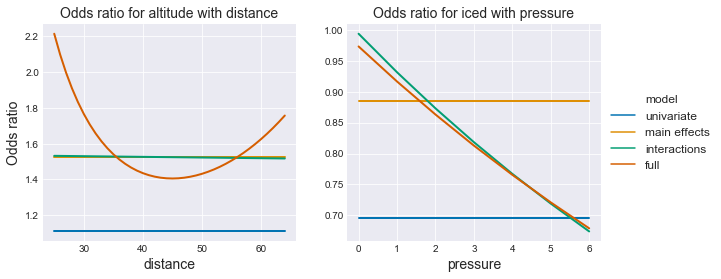

In [381]:
fig, axes = plt.subplots(1,2, sharey=False)
for OR_i, args, ax in zip(frames, args_all, axes):
    ax = sns.lineplot(x=args[1], y='OR', data=OR_i, hue='model', ax=ax, 
                      hue_order=['univariate', 'main effects', 'interactions', 'full'], 
                      linewidth=2)
    ax.set_title(f'Odds ratio for {args[0]} with {args[1]}', size=14)
    ax.set_xlabel(args[1], size=14)
    ax.set_ylabel('Odds ratio', size=14)
    ax.get_legend().remove()

ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=12)
ax.set_ylabel('')
fig.set_size_inches(10, 4)
plt.show()

### Analysis of Residuals

Using 137 bins.
94.9 % of train bins mean residuals within bounds.


Text(0.5, 1.0, 'Binned residuals on pred')

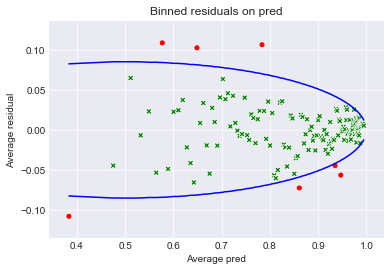

In [384]:
on = 'pred'
resid = binned_residuals(results['full'], df.drop('good', axis=1), df['good'], bins=None, on=on)
print(round(resid['inside'].mean()*100,1), r'% of train bins mean residuals within bounds.')
ax = plot_binned_residuals(resid, on=on)
ax.set_title(f'Binned residuals on {on}')

## With Matching

### Coarsening

In [184]:
def var_plot(data, var, cuts=3, func=pd.cut, bins=None, **kwargs):
    ax = sns.distplot(data[var], kde=False, bins=bins)    
    out, bins = func(data[var], cuts, retbins=True, **kwargs)
    for bin_ in bins:
        plt.axvline(bin_, color='r', linestyle='dashed', linewidth=2)
    return ax, out

IntervalIndex([(-0.019, 3.8], (3.8, 7.6], (7.6, 11.4], (11.4, 15.2], (15.2, 19.0]],
              closed='right',
              dtype='interval[float64]')

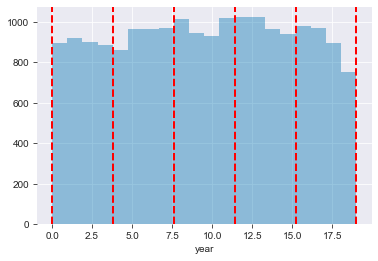

In [430]:
ax, bins = var_plot(df, 'year', cuts=5, bins=df['year'].nunique())
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(1, 4], (4, 10], (10, 18], (18, 30]],
              closed='right',
              dtype='interval[int64]')

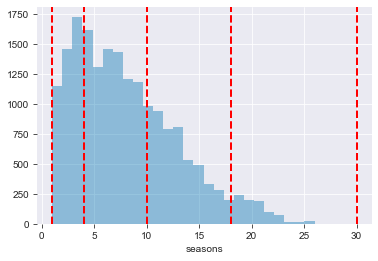

In [350]:
ax, bins = var_plot(df, 'seasons', cuts=[1,4,10,18,30], bins=df['seasons'].nunique(), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(-25, -5], (-5, 5], (5, 15], (15, 25], (25, 35], (35, 45]],
              closed='right',
              dtype='interval[int64]')

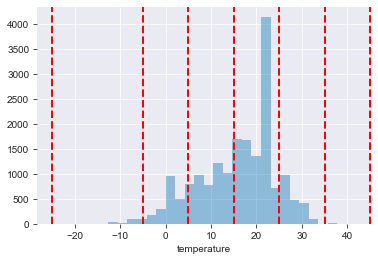

In [351]:
ax, bins = var_plot(df, 'temperature', cuts=[-25,-5,5,15,25,35,45], bins=int(df['temperature'].nunique()/2), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(-0.1, 12.0], (12.0, 25.0], (25.0, 41.0]],
              closed='right',
              dtype='interval[float64]')

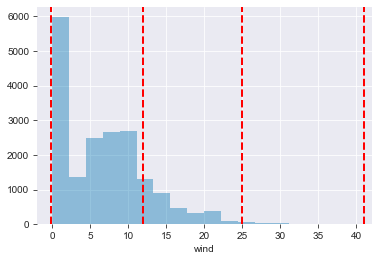

In [200]:
ax, bins = var_plot(df, 'wind', cuts=[-0.1,12,25,41], bins=int(df['wind'].nunique()/2), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories


IntervalIndex([(-0.006, 2.0], (2.0, 4.0], (4.0, 6.0]],
              closed='right',
              dtype='interval[float64]')

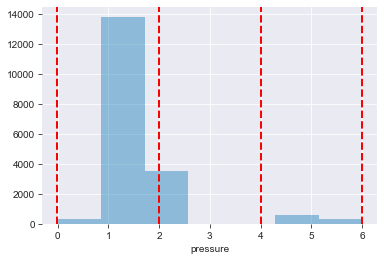

In [336]:
ax, bins = var_plot(df, 'pressure', cuts=3, bins=df['pressure'].nunique(), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(17, 22], (22, 27], (27, 32], (32, 37], (37, 42] ... (57, 62], (62, 67], (67, 72], (72, 77], (77, 82]],
              closed='right',
              dtype='interval[int64]')

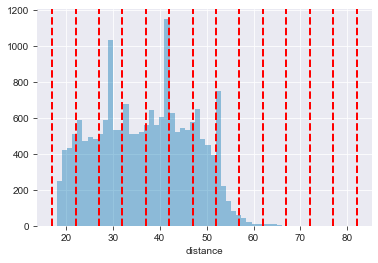

In [390]:
ax, bins = var_plot(df, 'distance', cuts=range(17,83,5), bins=int(df['distance'].nunique()), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

In [391]:
coarsening = {
    'distance': {'bins':range(17,100,6), 'cut': 'cut'}, # relax over
    'year': {'bins': 5, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0,4,10,18,30], 'cut': 'cut'},
    'temperature': {'bins': [-25,-5,5,15,25,35,45], 'cut': 'cut'},
    'wind': {'bins': [-0.1,12,25,41], 'cut': 'cut'},
    'pressure': {'bins': 3, 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening

{'distance': {'bins': range(17, 100, 6), 'cut': 'cut'},
 'year': {'bins': 5, 'cut': 'cut'},
 'seasons': {'bins': [0, 4, 10, 18, 30], 'cut': 'cut'},
 'temperature': {'bins': [-25, -5, 5, 15, 25, 35, 45], 'cut': 'cut'},
 'wind': {'bins': [-0.1, 12, 25, 41], 'cut': 'cut'},
 'pressure': {'bins': 3, 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'altitude': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

#### Imbalance

In [392]:
df_imb = None
multi = {}
matched = {}
t_matched = {}
uni = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    ub = cem.univariate_imbalance(coarsening).summary
    # print(ub)
    uni[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp)
    matched_ = cem.match(coarsening)>0
    matched[t] = matched_.sum()
    t_matched[t] = (df.loc[matched_, t] == 1).sum()/(df[t]==1).sum()*100
    multi[t] = cem.imbalance(coarsening)

df_imb = pd.DataFrame.from_dict(uni, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))
df_imb = df_imb.append(pd.DataFrame(matched, index=['% matched'])/len(df)*100)
df_imb = df_imb.append(pd.DataFrame(t_matched, index=['% treatment matched']))
# print(df_imb.to_latex())

In [393]:
df_imb

,altitude,iced,turf,postseason,away_game,precipitation
altitude,NaN,0.008***,0.0,0.023***,0.002,0.004**
away_game,0.051**,0.002,0.003,0.014,NaN,0.043***
distance,0.014,0.043***,0.012,0.018,0.014*,0.01
iced,0.04***,NaN,0.006,0.049***,0.002,0.035***
postseason,0.021***,0.015***,0.001,NaN,0.0,0.013***
precipitation,0.001,0.029***,0.004,0.053***,0.004,NaN
pressure,0.041,0.088***,0.004,0.013,0.004,0.022
seasons,0.012,0.022,0.037***,0.024,0.028***,0.039*
temperature,0.124***,0.068***,0.061,0.205***,0.02,0.134***
turf,0.0,0.033**,NaN,0.069***,0.003,0.048***


### Regressions

In [394]:
weights = {t:CEM(df, t, 'good', continuous, H=4).match(coarsening) for t in binary}
drop = {'altitude': ['turf'], 'turf': ['altitude']}

In [395]:
df_matched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model', 'treatment'])
results_matched = []
models = ['univariate', 'main effects', 'interactions', 'full']

for t, model in itertools.product(binary, models):
    if model == 'univariate':
        formula = f'good ~ {t}'
    elif model == 'main effects':
        formula = 'good ~ '+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns)
    elif model == 'interactions' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure'
    elif model == 'interactions':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure + altitude*distance'
    elif model == 'full' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        '+ np.log(wind+1) + np.log(seasons) + iced*pressure'
    elif model == 'full':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        ' + np.log(wind+1) + np.log(seasons) + iced*pressure + altitude*distance + altitude*np.log(distance)'
    # print(t, model)
    # print(formula)
    w = weights[t]
    glm = smf.glm(formula,
                data=df[w > 0],
                family=sm.families.Binomial(),
                var_weights=w[w > 0])
    result = glm.fit(method='bfgs', maxiter=1000)
    results_matched.append({'model': model, 'result':result, 'treatment': t})
    df_matched = pd.concat((df_matched, pd.DataFrame({'coef':result.params, 
                                                      'P>|z|':result.pvalues, 
                                                      'bse': result.bse,
                                                      'model':model, 
                                                      'treatment':t})))

df_matched.index.rename('covariate', inplace=True)
df_matched.reset_index('covariate', inplace=True)
results_matched = pd.DataFrame.from_records(results_matched)

In [396]:
df_matched.head(5)

,covariate,coef,P>|z|,bse,model,treatment
0,Intercept,1.649451,2.723849e-182,0.057289,univariate,altitude
1,altitude,0.158080,2.752168e-01,0.144877,univariate,altitude
2,Intercept,5.251166,1.728379e-40,0.394178,main effects,altitude
3,distance,-0.112198,4.782522e-55,0.007180,main effects,altitude
4,year,0.052658,8.370750e-07,0.010689,main effects,altitude


In [397]:
results_matched.head(5)

,model,result,treatment
0,univariate,<statsmodels.genmod.generalized_linear_model.G...,altitude
1,main effects,<statsmodels.genmod.generalized_linear_model.G...,altitude
2,interactions,<statsmodels.genmod.generalized_linear_model.G...,altitude
3,full,<statsmodels.genmod.generalized_linear_model.G...,altitude
4,univariate,<statsmodels.genmod.generalized_linear_model.G...,iced


In [501]:
def expand(row, filter_=False):
    summary = to_frame(row['result'].summary())
    summary['treatment'] = row['treatment']
    if filter_:
        summary = summary.loc[[row['treatment'] in c for c in summary.index]]
    return summary

#### Simple

In [504]:
results_uni = results_matched.loc[results_matched['model']=='univariate', :]
df_uni = pd.concat(results_uni.apply(expand, axis=1).to_list())
df_uni = df_uni.set_index('treatment', append=True).reorder_levels([1,0])
print(df_uni.to_latex())
df_uni

\begin{tabular}{llrrrrrr}
\toprule
              &               &    coef &  std err &       z &  P>|z| &  [0.025 &  0.975] \\
treatment & covariate &         &          &         &        &         &         \\
\midrule
altitude & Intercept &  1.6495 &    0.057 &  28.792 &  0.000 &   1.537 &   1.762 \\
              & altitude &  0.1581 &    0.145 &   1.091 &  0.275 &  -0.126 &   0.442 \\
iced & Intercept &  1.8077 &    0.033 &  55.427 &  0.000 &   1.744 &   1.872 \\
              & iced & -0.4360 &    0.070 &  -6.240 &  0.000 &  -0.573 &  -0.299 \\
turf & Intercept &  1.6658 &    0.033 &  50.187 &  0.000 &   1.601 &   1.731 \\
              & turf &  0.2063 &    0.049 &   4.202 &  0.000 &   0.110 &   0.302 \\
postseason & Intercept &  1.8833 &    0.053 &  35.511 &  0.000 &   1.779 &   1.987 \\
              & postseason &  0.0462 &    0.138 &   0.334 &  0.738 &  -0.225 &   0.317 \\
away\_game & Intercept &  1.8033 &    0.034 &  53.638 &  0.000 &   1.737 &   1.869 \\
              & 

0                              coef  std err       z  P>|z|  [0.025  0.975]
treatment     covariate                                                    
altitude      Intercept      1.6495    0.057  28.792  0.000   1.537   1.762
              altitude       0.1581    0.145   1.091  0.275  -0.126   0.442
iced          Intercept      1.8077    0.033  55.427  0.000   1.744   1.872
              iced          -0.4360    0.070  -6.240  0.000  -0.573  -0.299
turf          Intercept      1.6658    0.033  50.187  0.000   1.601   1.731
              turf           0.2063    0.049   4.202  0.000   0.110   0.302
postseason    Intercept      1.8833    0.053  35.511  0.000   1.779   1.987
              postseason     0.0462    0.138   0.334  0.738  -0.225   0.317
away_game     Intercept      1.8033    0.034  53.638  0.000   1.737   1.869
              away_game     -0.0324    0.048  -0.681  0.496  -0.126   0.061
precipitation Intercept      1.8843    0.041  46.154  0.000   1.804   1.964
              precipitation -0.3817    0.088  -4.360  0.000  -0.553  -0.210

#### Main effects

In [502]:
results_main = results_matched.loc[results_matched['model']=='main effects', :]
df_main = pd.concat(results_main.apply(lambda x: expand(x, True), axis=1).to_list())
df_main = df_main.set_index('treatment', append=True).reorder_levels([1,0])
print(df_main.to_latex())
df_main

\begin{tabular}{llrrrrrr}
\toprule
              &               &    coef &  std err &      z &  P>|z| &  [0.025 &  0.975] \\
treatment & covariate &         &          &        &        &         &         \\
\midrule
altitude & altitude &  0.2013 &    0.159 &  1.265 &  0.206 &  -0.111 &   0.513 \\
iced & iced & -0.2773 &    0.077 & -3.588 &  0.000 &  -0.429 &  -0.126 \\
turf & turf &  0.1934 &    0.055 &  3.538 &  0.000 &   0.086 &   0.301 \\
postseason & postseason &  0.1486 &    0.153 &  0.974 &  0.330 &  -0.151 &   0.448 \\
away\_game & away\_game & -0.0097 &    0.051 & -0.189 &  0.850 &  -0.110 &   0.090 \\
precipitation & precipitation & -0.3217 &    0.097 & -3.309 &  0.001 &  -0.512 &  -0.131 \\
\bottomrule
\end{tabular}



,,coef,std err,z,P>|z|,[0.025,0.975]
treatment,covariate,,,,,,
altitude,altitude,0.2013,0.159,1.265,0.206,-0.111,0.513
iced,iced,-0.2773,0.077,-3.588,0.000,-0.429,-0.126
turf,turf,0.1934,0.055,3.538,0.000,0.086,0.301
postseason,postseason,0.1486,0.153,0.974,0.330,-0.151,0.448
away_game,away_game,-0.0097,0.051,-0.189,0.850,-0.110,0.090
precipitation,precipitation,-0.3217,0.097,-3.309,0.001,-0.512,-0.131


#### Interactions

In [506]:
results_inters = results_matched.loc[results_matched['model']=='interactions', :]
df_inters = pd.concat(results_inters.apply(lambda x: expand(x, True), axis=1).to_list())
df_inters = df_inters.set_index('treatment', append=True).reorder_levels([1,0])
print(df_inters.to_latex())
df_inters

\begin{tabular}{llrrrrrr}
\toprule
              &               &    coef &  std err &      z &  P>|z| &  [0.025 &  0.975] \\
treatment & covariate &         &          &        &        &         &         \\
\midrule
altitude & altitude &  0.8180 &    0.875 &  0.935 &  0.350 &  -0.896 &   2.532 \\
              & altitude:distance & -0.0139 &    0.019 & -0.713 &  0.476 &  -0.052 &   0.024 \\
iced & iced & -0.1509 &    0.137 & -1.101 &  0.271 &  -0.419 &   0.118 \\
              & iced:pressure & -0.0948 &    0.085 & -1.114 &  0.265 &  -0.261 &   0.072 \\
turf & turf &  0.1909 &    0.055 &  3.491 &  0.000 &   0.084 &   0.298 \\
postseason & postseason &  0.1442 &    0.153 &  0.945 &  0.345 &  -0.155 &   0.443 \\
away\_game & away\_game & -0.0087 &    0.051 & -0.170 &  0.865 &  -0.109 &   0.091 \\
precipitation & precipitation & -0.3216 &    0.097 & -3.307 &  0.001 &  -0.512 &  -0.131 \\
\bottomrule
\end{tabular}



0                                  coef  std err      z  P>|z|  [0.025  0.975]
treatment     covariate                                                       
altitude      altitude           0.8180    0.875  0.935  0.350  -0.896   2.532
              altitude:distance -0.0139    0.019 -0.713  0.476  -0.052   0.024
iced          iced              -0.1509    0.137 -1.101  0.271  -0.419   0.118
              iced:pressure     -0.0948    0.085 -1.114  0.265  -0.261   0.072
turf          turf               0.1909    0.055  3.491  0.000   0.084   0.298
postseason    postseason         0.1442    0.153  0.945  0.345  -0.155   0.443
away_game     away_game         -0.0087    0.051 -0.170  0.865  -0.109   0.091
precipitation precipitation     -0.3216    0.097 -3.307  0.001  -0.512  -0.131

#### Non-linear transformations

In [507]:
results_full = results_matched.loc[results_matched['model']=='full', :]
df_full = pd.concat(results_full.apply(lambda x: expand(x, True), axis=1).to_list())
df_full = df_full.set_index('treatment', append=True).reorder_levels([1,0])
print(df_full.to_latex())
df_full

\begin{tabular}{llrrrrrr}
\toprule
              &               &     coef &  std err &      z &  P>|z| &  [0.025 &   0.975] \\
treatment & covariate &          &          &        &        &         &          \\
\midrule
altitude & altitude &  77.5426 &   30.179 &  2.569 &  0.010 &  18.393 &  136.692 \\
              & altitude:distance &   0.6634 &    0.256 &  2.588 &  0.010 &   0.161 &    1.166 \\
              & altitude:np.log(distance) & -28.2550 &   10.966 & -2.577 &  0.010 & -49.747 &   -6.763 \\
iced & iced &  -0.1548 &    0.137 & -1.126 &  0.260 &  -0.424 &    0.115 \\
              & iced:pressure &  -0.0920 &    0.085 & -1.080 &  0.280 &  -0.259 &    0.075 \\
turf & turf &   0.2299 &    0.058 &  3.972 &  0.000 &   0.116 &    0.343 \\
postseason & postseason &   0.1763 &    0.153 &  1.151 &  0.250 &  -0.124 &    0.476 \\
away\_game & away\_game &  -0.0099 &    0.051 & -0.195 &  0.845 &  -0.110 &    0.090 \\
precipitation & precipitation &  -0.3210 &    0.098 & -3.277 &  0.

0                                           coef  std err      z  P>|z|  \
treatment     covariate                                                   
altitude      altitude                   77.5426   30.179  2.569  0.010   
              altitude:distance           0.6634    0.256  2.588  0.010   
              altitude:np.log(distance) -28.2550   10.966 -2.577  0.010   
iced          iced                       -0.1548    0.137 -1.126  0.260   
              iced:pressure              -0.0920    0.085 -1.080  0.280   
turf          turf                        0.2299    0.058  3.972  0.000   
postseason    postseason                  0.1763    0.153  1.151  0.250   
away_game     away_game                  -0.0099    0.051 -0.195  0.845   
precipitation precipitation              -0.3210    0.098 -3.277  0.001   

0                                        [0.025   0.975]  
treatment     covariate                                   
altitude      altitude                   18.393  136.692  
              altitude:distance           0.161    1.166  
              altitude:np.log(distance) -49.747   -6.763  
iced          iced                       -0.424    0.115  
              iced:pressure              -0.259    0.075  
turf          turf                        0.116    0.343  
postseason    postseason                 -0.124    0.476  
away_game     away_game                  -0.110    0.090  
precipitation precipitation              -0.513   -0.129

#### Odds Ratios

In [405]:
formula_summaries = {'univariate':df_uni, 'main effects':df_main, 'interactions':df_inters, 'full':df_full}
args = {'altitude':['distance', range(25,65)], 'iced':['pressure', [0,1,2,3,4,5,6]]}
frames = {}

for treatment, hue in args.items():
    OR_mt = None
    for model_type, d in formula_summaries.items():
        d_t = d.loc[treatment, :]
        res_ = odds_ratios(d_t, treatment, hue[0], hue[1], plot=False, p=1)
        res_['model'] = model_type
        res_['treatment'] = treatment
        if OR_mt is None:
            OR_mt = res_
        else:
            OR_mt = pd.concat((OR_mt, res_))
    frames[treatment] = OR_mt


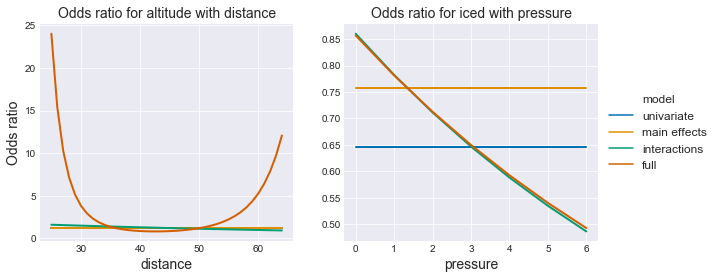

In [406]:
fig, axes = plt.subplots(1,2, sharey=False)
axes = {'altitude':axes[0], 'iced': axes[1]}
for treatment in ('altitude', 'iced'):
    ORs = frames[treatment]
    x = args[treatment][0]
    ax = sns.lineplot(x=x, y='OR', data=ORs, hue='model', ax=axes[treatment], hue_order=['univariate', 'main effects', 'interactions', 'full'], linewidth=2)
    ax.set_title(f'Odds ratio for {treatment} with {x}', size=14)
    ax.set_xlabel(x, size=14)
    ax.set_ylabel('Odds ratio', size=14)
    ax.get_legend().remove()

# axes[0].set_ylim(top=3.5)
# axes[0].set_xlim(25,65)

axes['iced'].legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=12)
axes['iced'].set_ylabel('')
fig.set_size_inches(10, 4)
plt.show()

#### SATT

In [444]:
from scipy.stats import ttest_rel
satts = []

for t in binary:
    # treated units
    nT = (df[t]==1).sum()

    # matched and unmatched treated units
    df_t_m = df.loc[(weights[t]>0) & (df[t]==1), :] # matched
    df_t_um = df.loc[(weights[t]==0) & (df[t]==1), :] # unmatched

    # observed outcomes for matched and unmatched treated units
    observed_m = df_t_m['good']
    observed_um = df_t_um['good']
    mT = len(observed_m) # matched treated units

    # counterfactual data points for matched treated units
    df_cf_m = df_t_m.copy()
    df_cf_m[t] = 0

    # counterfactuals for unmatched treated units
    df_cf_um = df_t_um.copy()
    df_cf_um[t] = 0

    for _, row in results_matched.iterrows():
        result = row['result']

        if row['treatment'] != t:
            continue

        # potential outcome for matched and unmatched treated unit counterfactuals
        potential_m = result.predict(df_cf_m)
        potential_um = result.predict(df_cf_um)

        # satt for matched and unmatched treated units and their counterfactuals
        satt_m = (observed_m-potential_m).mean().round(3)
        satt_um = (observed_um-potential_um).mean().round(3)

        # weighted satt combining matched and unmatched satts
        satt_w = round((satt_m*mT + satt_um*(nT-mT))/nT,3)

        # t-test for matched and unmatched treated units and their counterfactuals
        stat_m, p_m = ttest_rel(observed_m, potential_m)
        stat_um, p_um = ttest_rel(observed_um, potential_um)
        p_w = (p_m*mT + p_um*(nT-mT))/nT

        satts.append({'treatment':t, 'model':row['model'], 'local satt':str(satt_m)+pp(p_m), 'unmatched satt':str(satt_um)+pp(p_um), 'weighted satt':str(satt_w)+pp(p_w)})
df_satt = pd.DataFrame.from_records(satts).set_index(['treatment', 'model'])
# print(df_satt.to_latex())

In [445]:
df_satt.head(20)

local satt unmatched satt weighted satt
treatment  model                                               
altitude   univariate        0.018           0.02         0.019
           main effects      0.024         0.045*        0.029*
           interactions      0.025       0.084***         0.04*
           full             0.026*       0.082***         0.04*
iced       univariate    -0.036***      -0.109***      -0.06***
           main effects   -0.018**      -0.066***      -0.034**
           interactions   -0.018**      -0.079***      -0.038**
           full           -0.018**      -0.084***      -0.039**
turf       univariate     0.025***         -0.006         0.019
           main effects   0.019***       0.023***       0.02***
           interactions   0.019***       0.024***       0.02***
           full           0.024***       0.031***      0.025***
postseason univariate       -0.021       -0.056**        -0.032
           main effects     -0.012         -0.04*        -0.021
           interactions     -0.011         -0.037        -0.019
           full             -0.007         -0.015         -0.01
away_game  univariate       -0.006      -0.051***        -0.017
           main effects     -0.002       -0.018**        -0.006
           interactions     -0.002       -0.017**        -0.006
           full             -0.002       -0.019**        -0.006